In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import numpy as np
import math
from sklearn.utils import shuffle
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pickle
from kymatio.torch import Scattering1D
import pywt
import ipdb
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data

# CRASH_fname = 'CRASH_FE_filtered_subsampled_single.pkl'

# with open(CRASH_fname, 'rb') as handle:
#     F_t, adj_mx, adj_mx_idx, _input, _gt, coeffs, \
#     inv_mapping, region_assignment, nTrain, nValid, \
#     nTest, scaler_in, scaler_out = pickle.load(handle)

eeg_mat = np.load('eeg_mat.npy')

## same session, signals on different nodes

### kymatio

In [69]:
J = 6
Q = 12

base_len = 5120
node_num = 3

scattering = Scattering1D(J, base_len, Q)

sig = torch.from_numpy(eeg_mat[0,:base_len,:node_num]).transpose(0,1).contiguous()
coefs = scattering(sig)

print(coefs.shape)
print(scattering.meta()['order'])
order0, order1, order2 = (scattering.meta()['order']==0).sum(), (scattering.meta()['order']==1).sum(), (scattering.meta()['order']==2).sum()
print(order0, '0th order coef,', order1, '1st order coef,', order2, '2nd order coef.')

torch.Size([3, 177, 80])
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
1 0th order coef, 52 1st order coef, 124 2nd order coef.


plot signals


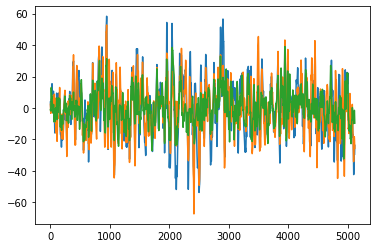

plot signals 0th coeffs


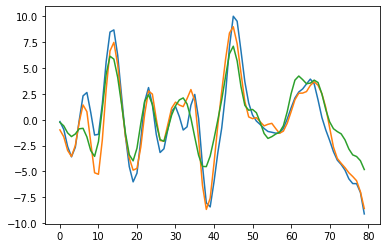

plot signals 1st coeffs


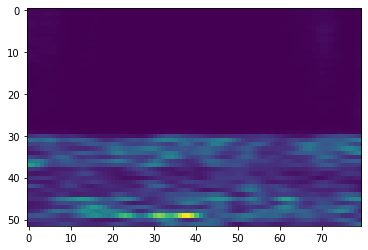

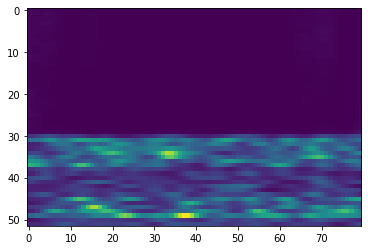

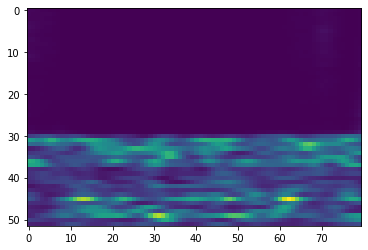

plot signals 2nd coeffs


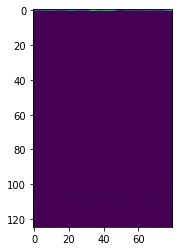

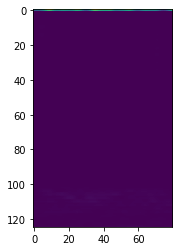

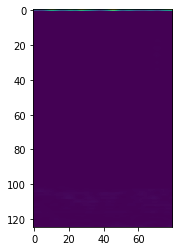

In [73]:
print('plot signals')
for i in range(node_num):
    plt.plot(sig[i])
plt.show()

print('plot signals 0th coeffs')
for i in range(node_num):
    plt.plot(coefs[i][0])
plt.show()

print('plot signals 1st coeffs')
for i in range(node_num):
    plt.figure()
    plt.imshow(coefs[i][order0:order0+order1])
plt.show()

print('plot signals 2nd coeffs')
for i in range(node_num):
    plt.figure()
    plt.imshow(coefs[i][order1:])
plt.show()

### pytorch wavelet

Fast. But only has discrete for 1d

In [77]:
from pytorch_wavelets import DWT1DForward, DWT1DInverse

In [83]:
dwt = DWT1DForward(wave='db12', J=6)
c,f = dwt(x[None,None,:])

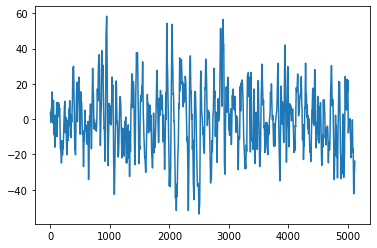

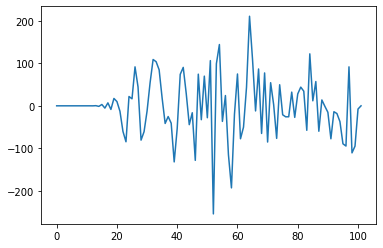

In [99]:
plt.plot(x)
plt.show()
plt.plot(c[0,0])

### pywt

The choice of mother wavelet & central frequency: Wavelets in Neuroscience (https://link.springer.com/book/10.1007/978-3-662-43850-3)P250: selection of mother wavelet. Complex Morlet seems the best for resting state signal  & P251: Morlet wavelet central frequency choose 2pi

Slow wave freq: 0.75 - 4Hz: https://www.sciencedirect.com/topics/medicine-and-dentistry/slow-brain-wave#:~:text=Slow-wave%20activity%20(SWA),the%200.75%E2%80%934.5%20Hz%20range.&text=SWA%20is%20defined%20as%20EEG,0.75%E2%80%934.5%20Hz%20for%20human.

So here scale up to a freq in between (~ 2.5)

In [107]:
pywt.scale2frequency('cmor6.2831852-3.1415926', np.arange(1,800)) * 640

array([2000.        , 1000.        ,  666.66666667,  500.        ,
        400.        ,  333.33333333,  285.71428571,  250.        ,
        222.22222222,  200.        ,  181.81818182,  166.66666667,
        153.84615385,  142.85714286,  133.33333333,  125.        ,
        117.64705882,  111.11111111,  105.26315789,  100.        ,
         95.23809524,   90.90909091,   86.95652174,   83.33333333,
         80.        ,   76.92307692,   74.07407407,   71.42857143,
         68.96551724,   66.66666667,   64.51612903,   62.5       ,
         60.60606061,   58.82352941,   57.14285714,   55.55555556,
         54.05405405,   52.63157895,   51.28205128,   50.        ,
         48.7804878 ,   47.61904762,   46.51162791,   45.45454545,
         44.44444444,   43.47826087,   42.55319149,   41.66666667,
         40.81632653,   40.        ,   39.21568627,   38.46153846,
         37.73584906,   37.03703704,   36.36363636,   35.71428571,
         35.0877193 ,   34.48275862,   33.89830508,   33.33333

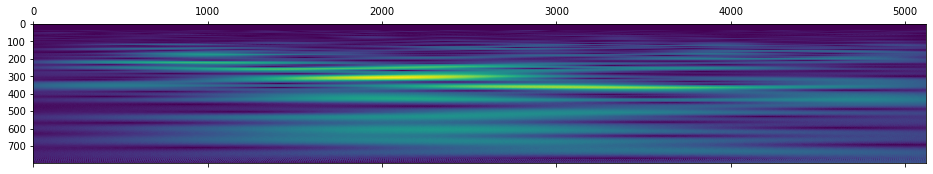

In [20]:
x = eeg_mat[0,:,0][:5120]
coef, f = pywt.cwt(x, np.arange(1,801), 'cmor6.2831852-3.1415926', 1.0/640)
plt.matshow(abs(coef))

In [4]:
class VanillaVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

device = 'cuda:0'
model = VanillaVAE(1, 128).to(device)

torch.Size([2, 1, 64, 64])

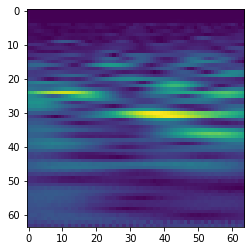

In [7]:
tmp = torch.tensor(abs(coef[None,None,...])).to(device)
tmp = F.interpolate(tmp, (64,64))
plt.imshow(tmp[0,0].cpu().numpy())
tmp = torch.cat((tmp, tmp))
tmp.shape

In [3]:
print(eeg_mat.shape)
basic_len = 5120
idxer = np.arange(basic_len)[None, :] + np.arange(0, eeg_mat.shape[1] - basic_len + 1, basic_len)[:, None]
data = eeg_mat[:, idxer, :]
del eeg_mat
print(data.shape)

# data = data.transpose(0,1,3,2)
# data = data.reshape(-1, data.shape[-1])
data = data[..., 5]
data = data.reshape(-1, data.shape[-1])

(240, 189282, 61)


(240, 36, 5120, 61)

In [8]:
coefs = []
for i in tqdm(range(len(data))):
    coef, f = pywt.cwt(data[i], np.arange(1,801), 'cmor6.2831852-3.1415926', 1.0/640)
    coefs.append(coef)

  2%|▏         | 205/8640 [24:09<16:33:58,  7.07s/it]


KeyboardInterrupt: 

In [10]:
with open('eeg_coefs_:205.pkl', 'wb') as handle:
    pickle.dump(coefs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('eeg_coefs_:205.pkl', 'rb') as handle:
    data = pickle.load(handle)
data = abs(np.stack(data))[:,None,...]
data = F.interpolate(torch.from_numpy(data), (64,64))

In [12]:
nTrain = 160
nValid = 25
nTest = 20
dTrain = data[:nTrain].to(device)
dVal = data[nTrain:nTrain+nValid].to(device)
dTest = data[-nTest:].to(device)

num_epoch = 50
batch_size = 16
lrate = 3e-3
wdecay = 4e-3


train_loss = []
val_loss = []

for e in range(num_epoch):
#     if e%50 == 0 and e>0:
#         lrate = lrate * 0.8
    optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)
    
    # train part
    model.train()
    # shuffle
    dTrain = shuffle(dTrain)
    cur_loss = []
    for i in tqdm(range(nTrain//batch_size)):
        batch_data = dTrain[i*batch_size:(i+1)*batch_size]
        res = model(batch_data)
        loss = model.loss_function(*res, M_N = batch_size/ nTrain)
        
        cur_loss.append(loss['loss'].item())
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
    
    train_loss.append(np.mean(cur_loss))
    print('epoch',e, 'train loss', train_loss[-1])
    model.eval()
    with torch.no_grad():
        res = model(dVal)
        loss = model.loss_function(*res, M_N = 1)
    val_loss.append(loss['loss'].item())
    print('val loss', val_loss[-1])
    
        

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0 train loss 146.76290893554688
val loss 313.5030517578125
epoch 1 train loss 144.72423553466797
val loss 156.0198211669922


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 2 train loss 143.34526901245118
val loss 118.17784881591797
epoch 3 train loss 143.03453063964844
val loss 109.83099365234375


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 4 train loss 141.9744094848633
val loss 108.83759307861328
epoch 5 train loss 142.06191177368163
val loss 108.92618560791016


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 6 train loss 141.73487014770507
val loss 107.57283020019531
epoch 7 train loss 141.47743225097656
val loss 107.21853637695312


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 8 train loss 141.7128776550293
val loss 107.50495910644531
epoch 9 train loss 141.7029914855957
val loss 107.4609603881836


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 10 train loss 141.5198486328125
val loss 107.30584716796875
epoch 11 train loss 141.58481140136718
val loss 108.22687530517578


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 12 train loss 141.890234375
val loss 114.0290756225586
epoch 13 train loss 142.26567840576172
val loss 107.65594482421875


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 14 train loss 141.64911117553712
val loss 107.31098937988281
epoch 15 train loss 141.74383697509765
val loss 108.1640853881836


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 16 train loss 141.68811721801757
val loss 107.26487731933594
epoch 17 train loss 141.7153434753418
val loss 108.17350769042969


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 18 train loss 141.68046340942382
val loss 107.20915985107422
epoch 19 train loss 141.59415588378906
val loss 107.16827392578125


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 20 train loss 141.7248649597168
val loss 107.35961151123047
epoch 21 train loss 141.736767578125
val loss 114.45988464355469


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 22 train loss 141.68566970825196
val loss 117.23780059814453
epoch 23 train loss 141.81229095458986
val loss 125.9891357421875


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 24 train loss 141.68051223754884
val loss 107.38011169433594
epoch 25 train loss 141.70388412475586
val loss 111.47491455078125


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 26 train loss 141.74423828125
val loss 107.15593719482422
epoch 27 train loss 141.4982650756836
val loss 107.16163635253906


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 28 train loss 141.45896606445314
val loss 107.39334869384766
epoch 29 train loss 141.44213333129883
val loss 107.28336334228516


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 30 train loss 141.4323585510254
val loss 107.20317077636719
epoch 31 train loss 141.41298065185546
val loss 107.1783447265625


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 32 train loss 141.42013854980468
val loss 107.35191345214844
epoch 33 train loss 141.4086166381836
val loss 107.15258026123047


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 34 train loss 141.40605850219725
val loss 107.14903259277344
epoch 35 train loss 141.40562896728517
val loss 107.14767456054688


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 36 train loss 141.40436019897462
val loss 107.14790344238281
epoch 37 train loss 141.40423126220702
val loss 107.14749145507812


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 38 train loss 141.40436553955078
val loss 107.147216796875
epoch 39 train loss 141.40460357666015
val loss 107.1472396850586


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 40 train loss 141.40424652099608
val loss 107.14716339111328
epoch 41 train loss 141.4044090270996
val loss 107.14736938476562


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 42 train loss 141.40457458496093
val loss 107.14722442626953
epoch 43 train loss 141.40440673828124
val loss 107.14799499511719


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 44 train loss 141.4045310974121
val loss 107.14700317382812
epoch 45 train loss 141.40425338745118
val loss 107.14777374267578


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 46 train loss 141.4046203613281
val loss 107.1471939086914
epoch 47 train loss 141.4048324584961
val loss 107.14734649658203


100%|██████████| 10/10 [00:00<00:00, 60.08it/s]

epoch 48 train loss 141.40447082519532
val loss 107.14723205566406
epoch 49 train loss 141.4047653198242
val loss 107.14735412597656


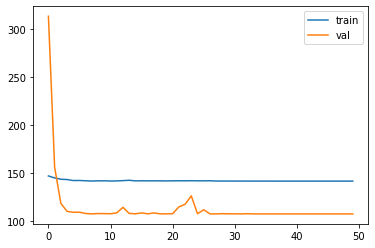

In [13]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

In [14]:
with torch.no_grad():
    test_out = model(dTest)
test_out[0].shape

torch.Size([20, 1, 64, 64])

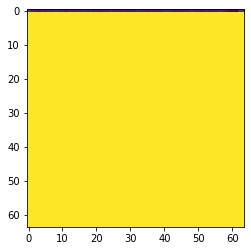

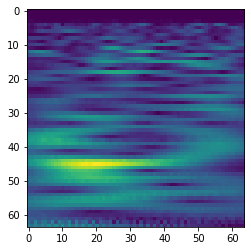

In [15]:
plt.imshow(test_out[0][0].detach().cpu().numpy().squeeze())
plt.show()
plt.imshow(test_out[1][0].detach().cpu().numpy().squeeze())
plt.show()